# <center> Assignment Reinforcement Learning

### <center> Ali Charara

In [162]:
from abc import ABC, abstractmethod
import contextlib
from enum import Enum
import sys
import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import text_flappy_bird_gym

In [151]:
NUM_DX_STATE = 14
NUM_DY_STATE = 22
MIN_DY = -11

def flatten_index(i, j):
    return i * NUM_DY_STATE +  (j - MIN_DY)

In [146]:
class TfbAction(int, Enum):
    IDLE = 0
    FLAP = 1

class BaseActionAgent(ABC):
    def __init__(self):
        pass

    def agent_init(self, agent_init_info, seed):
        """Setup for the agent called when the experiment first starts.

        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }

        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(seed=seed)

        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros(
            (self.num_states, self.num_actions)
        )  # The array of action-value estimates.

    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(
                self.num_actions
            )  # random action selection
        else:
            action = self.argmax(current_q)  # greedy action selection
        self.prev_state = state
        self.prev_action = action
        return action

    @abstractmethod
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        raise NotImplementedError

    @abstractmethod
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        raise NotImplementedError

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)
    
    def policy(self, obs):
        return self.argmax(self.q[obs])
   

In [184]:
def test_agent(agent: BaseActionAgent, max_score = None, is_obs_flatten = True, is_render=True) -> int:
    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset()[0]

    # iterate
    done = False
    while not done:

        # Select next action
        action = agent.policy(flatten_index(*obs) if is_obs_flatten else obs)
        # Appy action and return new observation of the environment
        obs, _, done, _, info = env.step(action)
        
        # Render the game
        if is_render:
            clear_output(wait=True)
            sys.stdout.write(env.render())
            time.sleep(0.2) # FPS
        
        if max_score is not None and info["score"] == max_score:
            break
        
    env.close()

    return info["score"]

## I] React Agent

We first found a fairly simple policy to implement and tested TFB on it. The considered agent is a simple react agent and actually performs pretty well with few engineering underneath. We could try to improve it incrementally but we will dive deeper into Model free control agents which will implicitely learn a policy through experience.

In [122]:
class ReactAgent(BaseActionAgent): 
    def agent_step(self, reward, state):
        pass
    
    def agent_end(self, reward):
        pass
    
    def policy(self, obs):
        dx, dy = obs
        return TfbAction.FLAP if dy >= 0 or (dx>=3 and -3<dy<0) else TfbAction.IDLE


In [124]:
with contextlib.suppress(KeyboardInterrupt):
    agent = ReactAgent()
    test_agent(agent, is_obs_flatten=False)

Text Flappy Bird!
Score: 23
----------------------
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[                    ]
[                    ]
[                    ]
[                    ]
[     *|         |   ]
[      |         |   ]
[      |         |   ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=0,dy=2)


## II] Model free control Agents

We can model the environnement of text flappy bird as being a MDP. This markov process is unknown, therefore we will need to improve the performances and learn policies in a model free setting. The two agents we will adapt here are the Expected Sarsa agent as well as the Q learning agent.

In [138]:
AGENT_INIT_INFO = {
    "num_actions": 2,
    "num_states": 14 * 22,
    "epsilon": 0.1,
    "step_size": 0.35,
    "discount": 0.99,
}

SEED = 7

EPISODES = 100000

In [147]:
class QLearningAgent(BaseActionAgent):
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        self.q[self.prev_state, self.prev_action] += self.step_size * (
            reward
            + self.discount * np.max(self.q[state, :])
            - self.q[self.prev_state, self.prev_action]
        )

        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.q[self.prev_state, self.prev_action] += self.step_size * (
            reward - self.q[self.prev_state, self.prev_action]
        )


In [148]:
class ExpectedSarsaAgent(BaseActionAgent):
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        policy = self.epsilon / self.num_actions * np.ones(self.num_actions)
        best_action = np.argmax(self.q[state, :])
        policy[best_action] += 1 - self.epsilon
        self.q[self.prev_state, self.prev_action] += self.step_size * (
            reward
            + self.discount * self.q[state, :] @ policy
            - self.q[self.prev_state, self.prev_action]
        )

        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.q[self.prev_state, self.prev_action] += self.step_size * (
            reward - self.q[self.prev_state, self.prev_action]
        )


In [199]:
def train_action_agent(agent: BaseActionAgent, max_score = None):
    for _ in tqdm(range(EPISODES)):
        env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
        obs = env.reset()[0]
        action = agent.agent_start(flatten_index(*obs))

        done = False
        while not done:
            obs, reward, done, _, info = env.step(action)

            # no rendering
            if done:
                agent.agent_end(reward)
                break
            
            if max_score is not None and info["score"] == max_score:
                break

            action = agent.agent_step(reward, flatten_index(*obs))

    return agent

In [142]:
qlearning_agent = QLearningAgent()
qlearning_agent.agent_init(AGENT_INIT_INFO, SEED)
qlearning_agent = train_action_agent(qlearning_agent)

100%|██████████| 100000/100000 [06:06<00:00, 272.57it/s]


In [157]:
with contextlib.suppress(KeyboardInterrupt):
    test_agent(qlearning_agent)

Text Flappy Bird!
Score: 132
----------------------
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |  @      |      ]
[   |                ]
[                    ]
[                    ]
[                    ]
[             |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=7,dy=-3)


In [158]:
esarsa_agent = ExpectedSarsaAgent()
esarsa_agent.agent_init(AGENT_INIT_INFO, SEED)
esarsa_agent = train_action_agent(esarsa_agent)


100%|██████████| 100000/100000 [05:45<00:00, 289.53it/s]


In [159]:
with contextlib.suppress(KeyboardInterrupt):    
    test_agent(esarsa_agent)

Text Flappy Bird!
Score: 152
----------------------
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |             ]
[      |             ]
[      |             ]
[      |             ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[                |   ]
[                |   ]
[      @         |   ]
[                |   ]
[      |         |   ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=0,dy=0)


## III] Comparison of the agents

Now that we have learnt the policies and verified that our agents indeed perform well, we'll compare both agents by plotting their state-value functions as well as their gap in performance depending on different parameters.

### 1. State-Value $V(dx, dy)$ plots


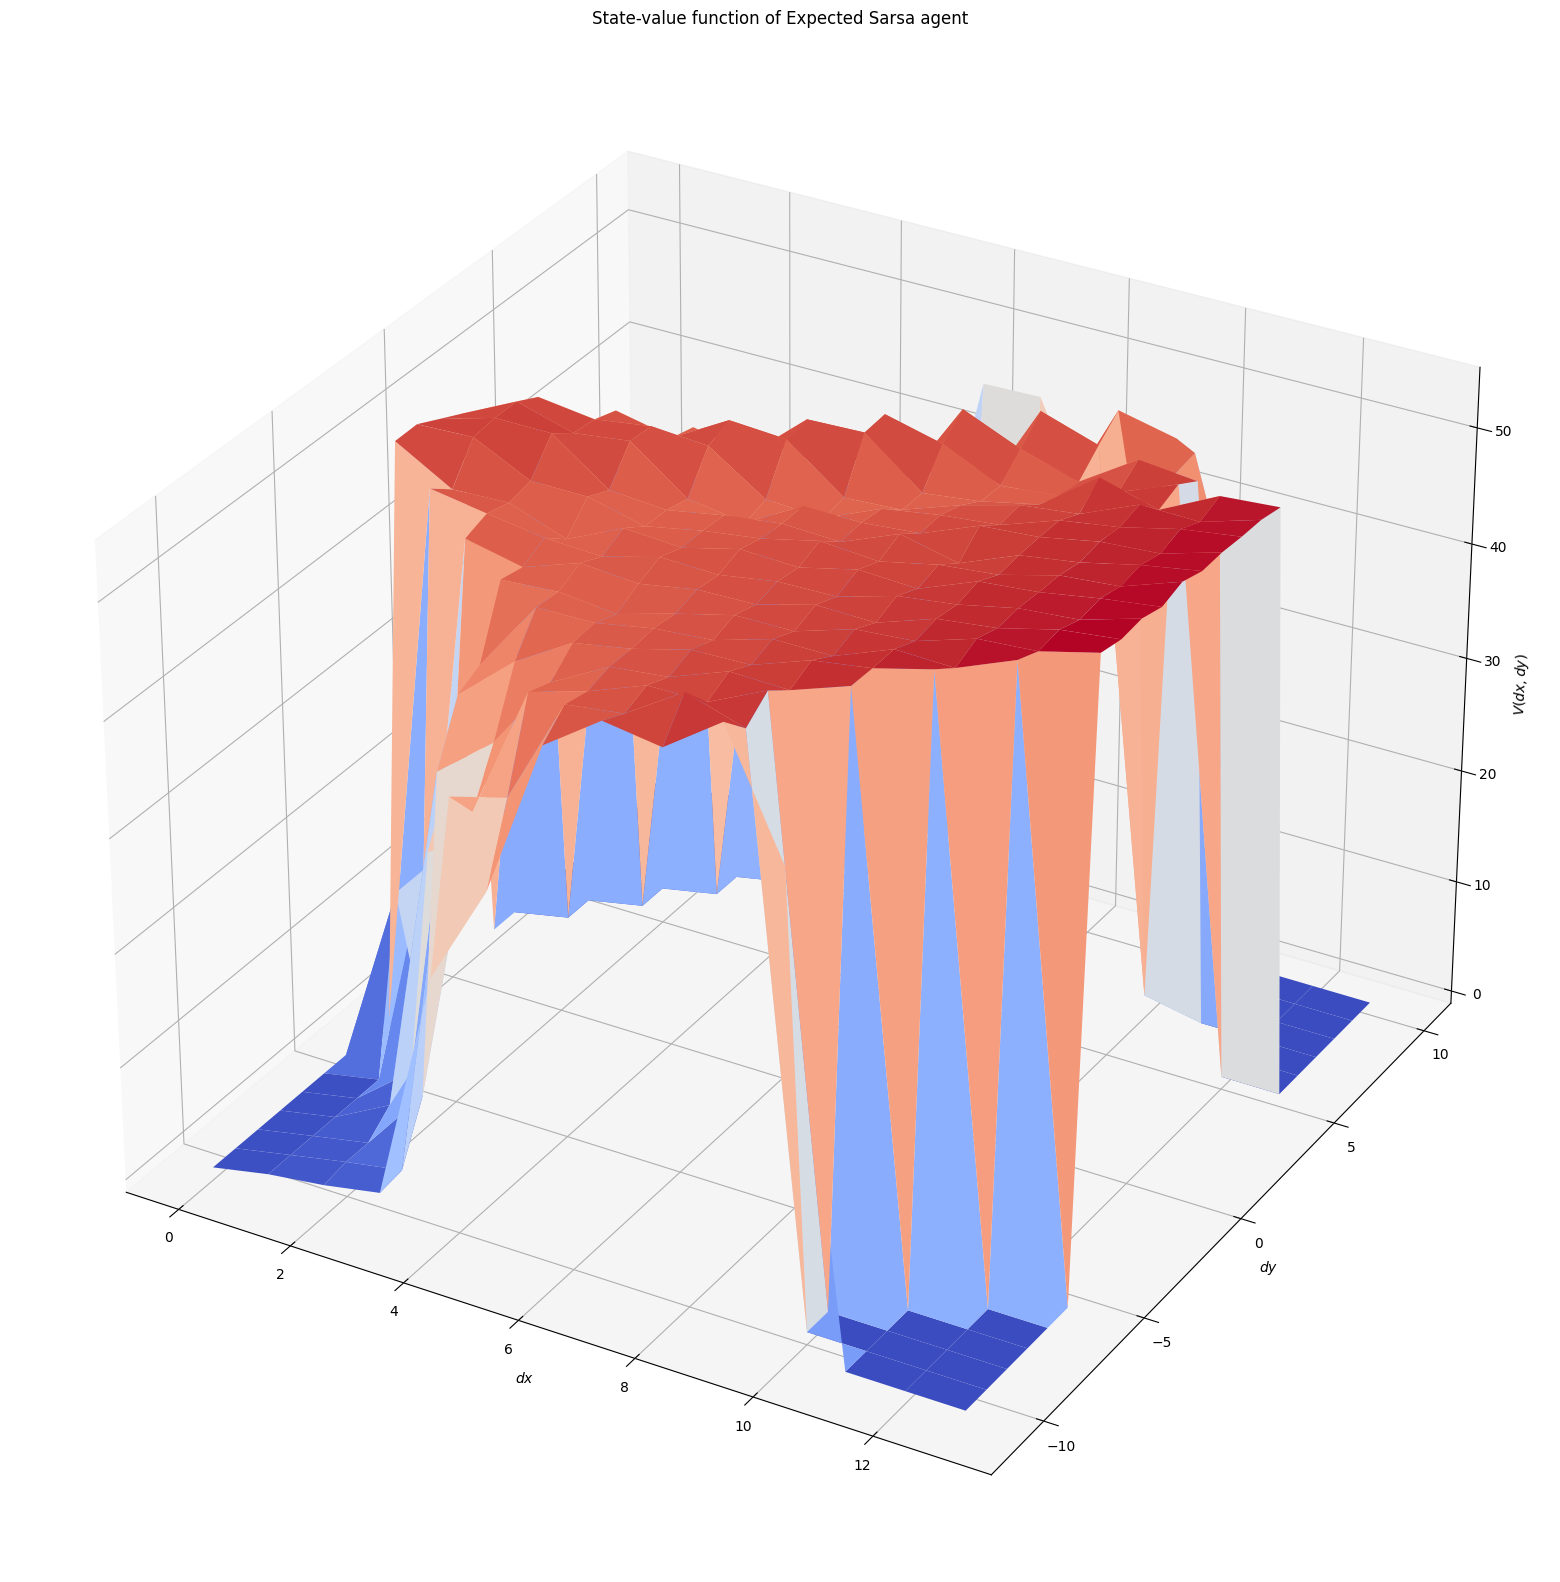

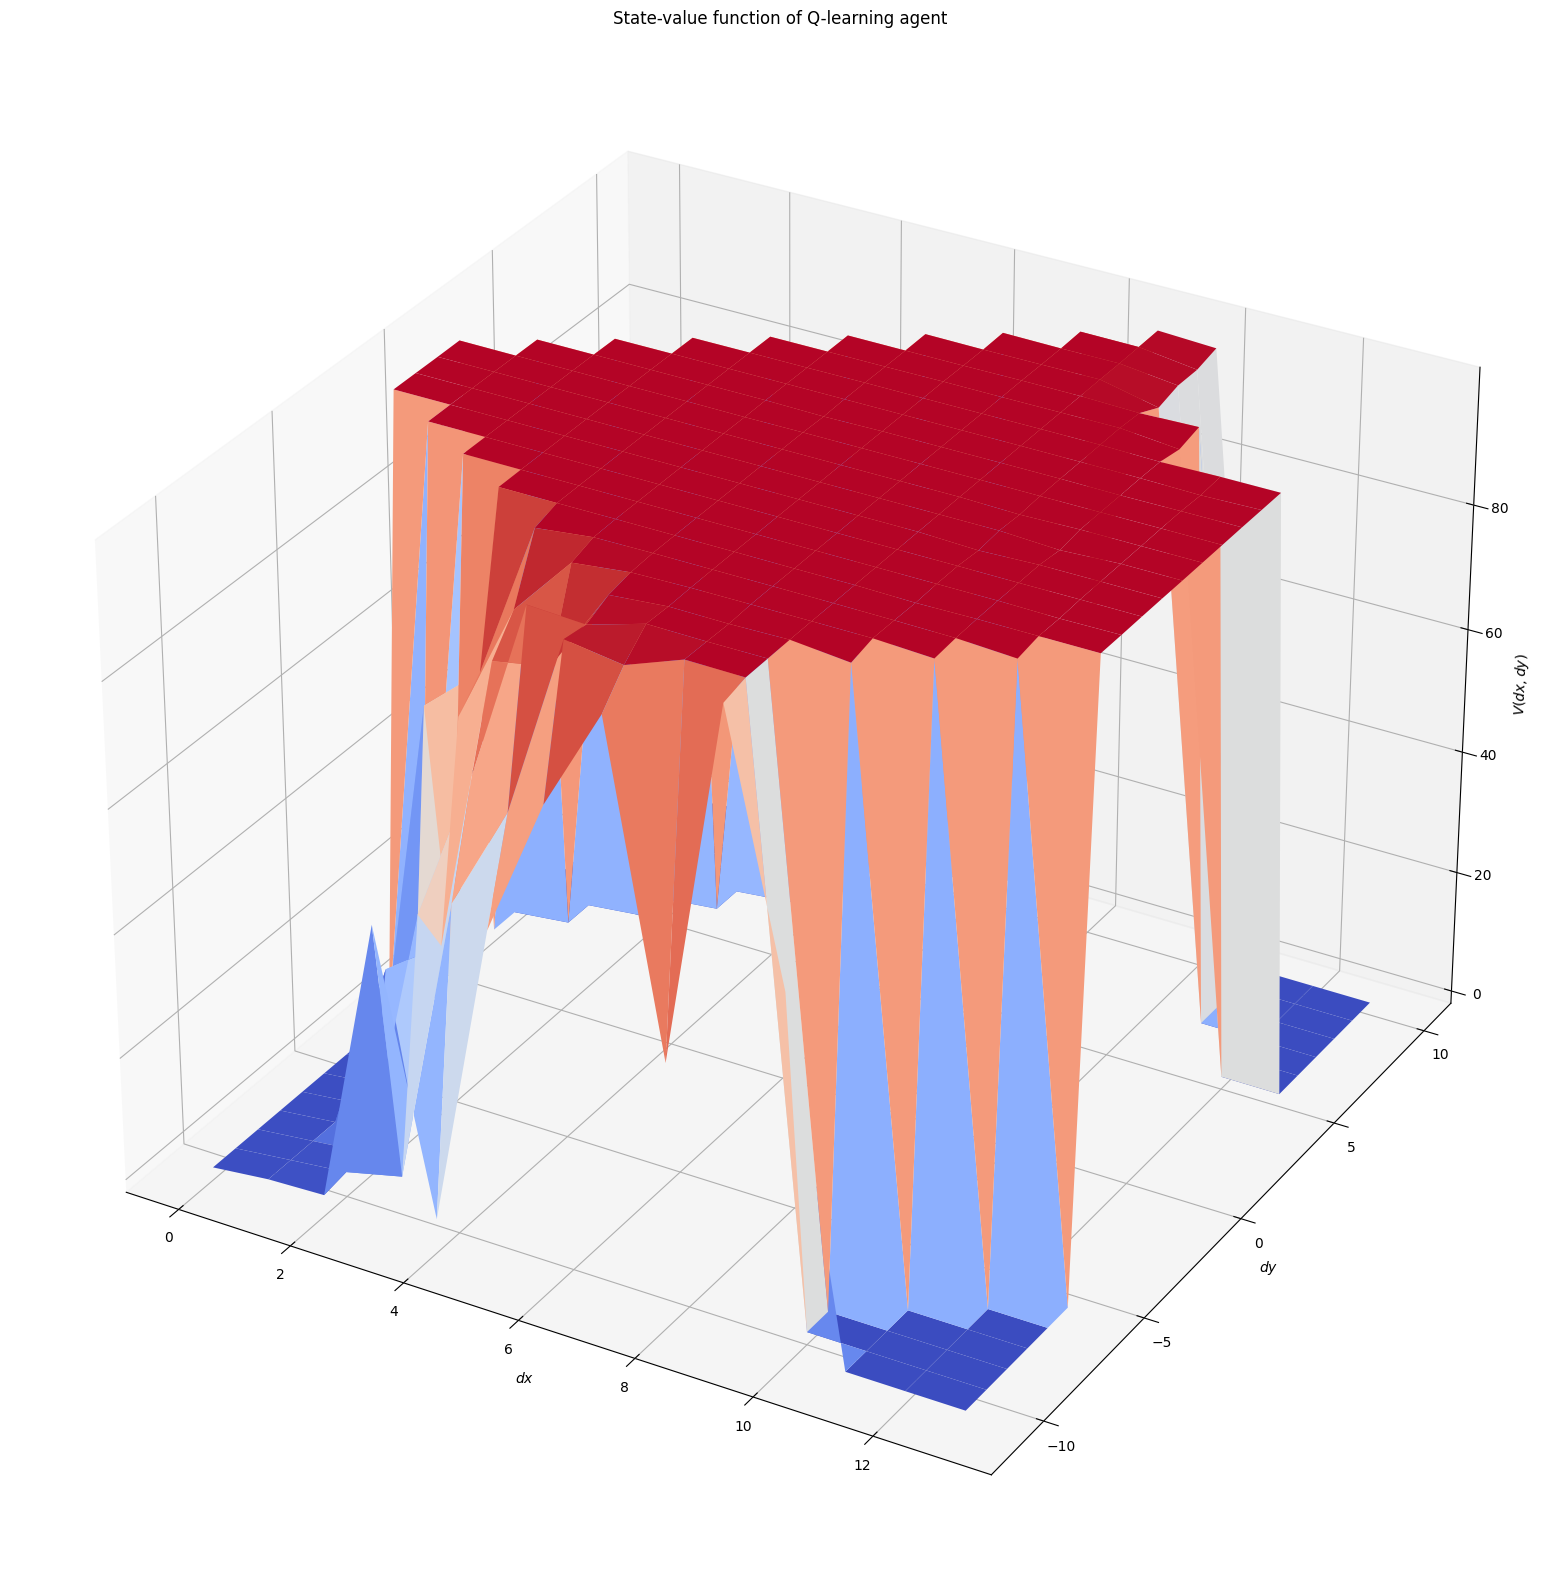

In [171]:
def plot_state_value_function(q_values, agent_name):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    def _get_value(dx, dy):
        return np.max(q_values[flatten_index(dx, dy)])
    
    x = np.array(range(NUM_DX_STATE))
    y = np.array(range(MIN_DY, NUM_DY_STATE + MIN_DY))
    X, Y = np.meshgrid(x, y)

    Z = np.array([_get_value(dx,dy) for dx,dy in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.set_xlabel("$dx$")
    ax.set_ylabel("$dy$")
    ax.set_zlabel("$V(dx, dy)$")
    ax.set_title(f"State-value function of {agent_name} agent")
    
    plt.show()

plot_state_value_function(esarsa_agent.q, "Expected Sarsa")
plot_state_value_function(qlearning_agent.q, "Q-learning")

### 2. Discount $\gamma$ impact

In [200]:
### train
AGENT_INIT_INFO = {
    "num_actions": 2,
    "num_states": 14 * 22,
    "epsilon": 0.1,
    "step_size": 0.35,
    "discount": 0.99,
}

SEED = 7
EPISODES = 10000

### tests
GAMMA_GRID = np.arange(0, 1.1, .1)

NUM_TESTS = 10
MAX_SCORE = 10000

### plots
FIGSIZE = (15,5)

In [201]:
ql_mean_scores = []
es_mean_scores = []

for gamma in GAMMA_GRID:
    AGENT_INIT_INFO["discount"] = gamma
    ql_agent = QLearningAgent()
    ql_agent.agent_init(AGENT_INIT_INFO, SEED)
    ql_agent = train_action_agent(ql_agent, max_score=MAX_SCORE)

    ql_mean_scores.append(
        np.array(
            [test_agent(ql_agent, max_score=MAX_SCORE, is_render=False) for _ in range(NUM_TESTS)]
        ).mean()
    )

    es_agent = ExpectedSarsaAgent()
    es_agent.agent_init(AGENT_INIT_INFO, SEED)
    es_agent = train_action_agent(es_agent, max_score=MAX_SCORE)

    es_mean_scores.append(
        np.array(
            [test_agent(es_agent, max_score=MAX_SCORE, is_render=False) for _ in range(NUM_TESTS)]
        ).mean()
    )


100%|██████████| 10000/10000 [00:30<00:00, 323.76it/s]


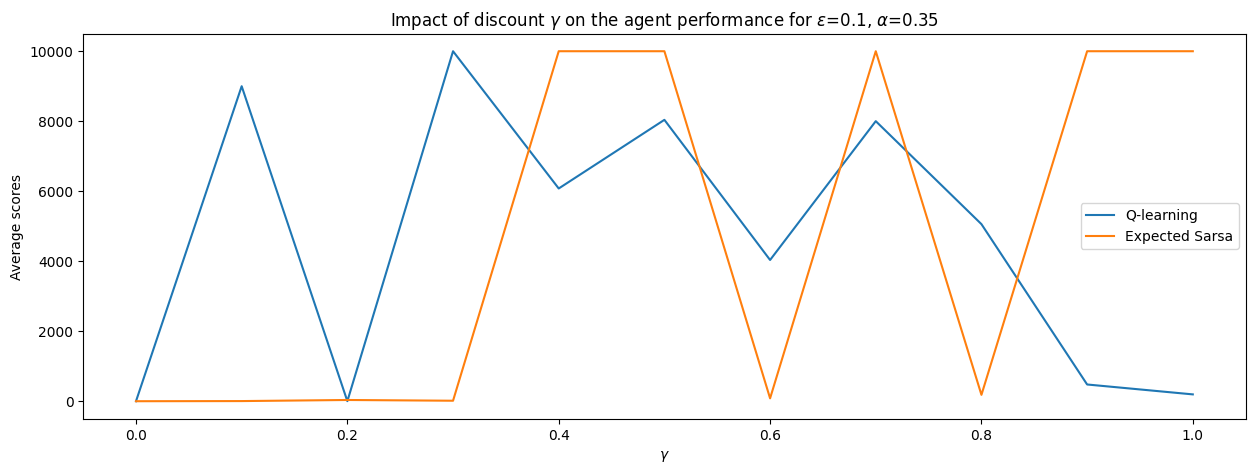

In [202]:
plt.figure(figsize=FIGSIZE)

plt.plot(GAMMA_GRID, ql_mean_scores)
plt.plot(GAMMA_GRID, es_mean_scores)

plt.xlabel("$\gamma$")
plt.ylabel("Average scores")

plt.title(
    "Impact of discount $\gamma$ on the agent performance for "
    f"$\epsilon$={AGENT_INIT_INFO['epsilon']}, $\\alpha$={AGENT_INIT_INFO['step_size']}"
)
plt.legend(("Q-learning", "Expected Sarsa"))

plt.show()

### 3. Exploration frequency $\epsilon$ impact

In [204]:
### train
AGENT_INIT_INFO = {
    "num_actions": 2,
    "num_states": 14 * 22,
    "epsilon": 0.1,
    "step_size": 0.35,
    "discount": 0.99,
}

### tests
EPSILON_GRID = np.arange(0, 1.1, .1)

In [205]:
ql_mean_scores = []
es_mean_scores = []

for epsilon in EPSILON_GRID:
    AGENT_INIT_INFO["epsilon"] = epsilon
    ql_agent = QLearningAgent()
    ql_agent.agent_init(AGENT_INIT_INFO, SEED)
    ql_agent = train_action_agent(ql_agent, max_score=MAX_SCORE)

    ql_mean_scores.append(
        np.array(
            [test_agent(ql_agent, max_score=MAX_SCORE, is_render=False) for _ in range(NUM_TESTS)]
        ).mean()
    )

    es_agent = ExpectedSarsaAgent()
    es_agent.agent_init(AGENT_INIT_INFO, SEED)
    es_agent = train_action_agent(es_agent, max_score=MAX_SCORE)

    es_mean_scores.append(
        np.array(
            [test_agent(es_agent, max_score=MAX_SCORE, is_render=False) for _ in range(NUM_TESTS)]
        ).mean()
    )


100%|██████████| 10000/10000 [00:04<00:00, 2358.22it/s]


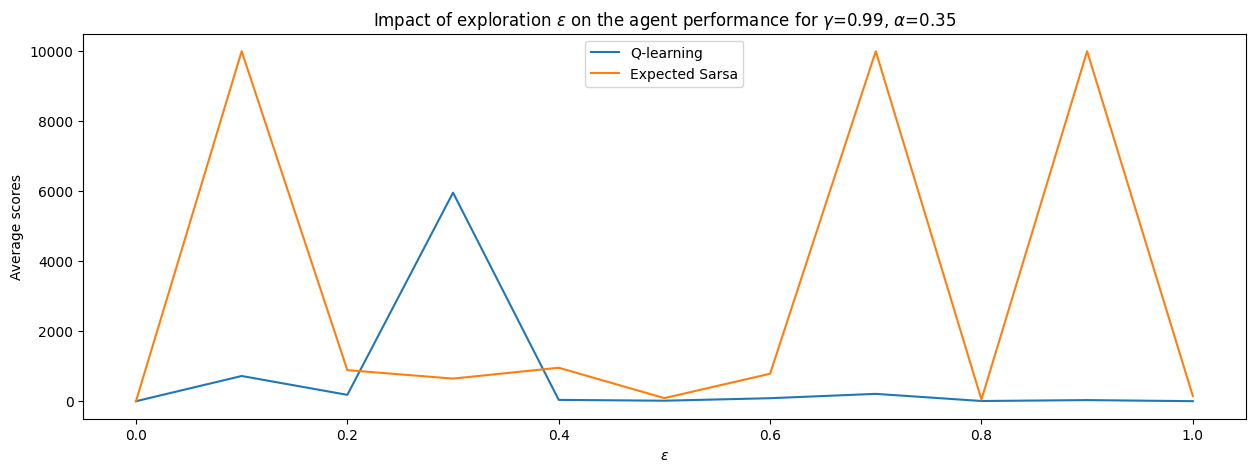

In [206]:
plt.figure(figsize=FIGSIZE)

plt.plot(EPSILON_GRID, ql_mean_scores)
plt.plot(EPSILON_GRID, es_mean_scores)

plt.xlabel("$\epsilon$")
plt.ylabel("Average scores")

plt.title(
    "Impact of exploration $\epsilon$ on the agent performance for "
    f"$\gamma$={AGENT_INIT_INFO['discount']}, $\\alpha$={AGENT_INIT_INFO['step_size']}"
)
plt.legend(("Q-learning", "Expected Sarsa"))
plt.show()

### 4. Step size $\alpha$ impact

In [207]:
### train
AGENT_INIT_INFO = {
    "num_actions": 2,
    "num_states": 14 * 22,
    "epsilon": 0.1,
    "step_size": 0.35,
    "discount": 0.99,
}

### tests
ALPHA_GRID = np.arange(0, 1.1, .1)

In [208]:
ql_mean_scores = []
es_mean_scores = []

for alpha in ALPHA_GRID:
    AGENT_INIT_INFO["step_size"] = alpha
    ql_agent = QLearningAgent()
    ql_agent.agent_init(AGENT_INIT_INFO, SEED)
    ql_agent = train_action_agent(ql_agent, max_score=MAX_SCORE)

    ql_mean_scores.append(
        np.array(
            [test_agent(ql_agent, max_score=MAX_SCORE, is_render=False) for _ in range(NUM_TESTS)]
        ).mean()
    )

    es_agent = ExpectedSarsaAgent()
    es_agent.agent_init(AGENT_INIT_INFO, SEED)
    es_agent = train_action_agent(es_agent, max_score=MAX_SCORE)

    es_mean_scores.append(
        np.array(
            [test_agent(es_agent, max_score=MAX_SCORE, is_render=False) for _ in range(NUM_TESTS)]
        ).mean()
    )

100%|██████████| 10000/10000 [00:15<00:00, 655.92it/s]


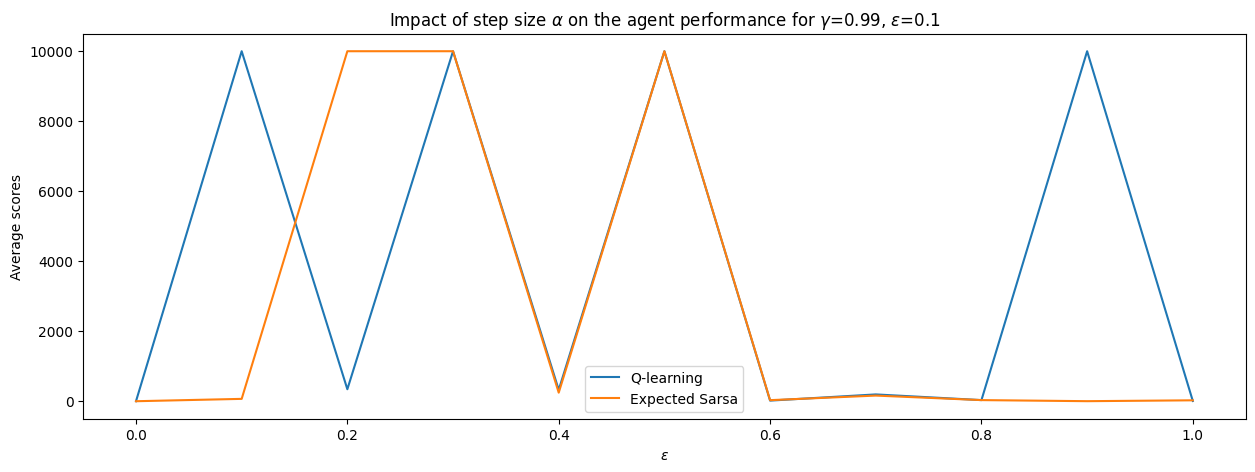

In [209]:
plt.figure(figsize=FIGSIZE)

plt.plot(ALPHA_GRID, ql_mean_scores)
plt.plot(ALPHA_GRID, es_mean_scores)

plt.xlabel("$\epsilon$")
plt.ylabel("Average scores")

plt.title(
    "Impact of step size $\\alpha$ on the agent performance for "
    f"$\gamma$={AGENT_INIT_INFO['discount']}, $\epsilon$={AGENT_INIT_INFO['epsilon']}"
)
plt.legend(("Q-learning", "Expected Sarsa"))
plt.show()